In [2]:
#from user_functions import *
import xarray as xr
import pandas as pd
import cartopy.geodesic as cgeo
import scipy.stats as stats

In [3]:
#function to read the raw tracker output (.txt files) and extract data into pd DataFrame rows. 
def get_track_info(period,sim,stamp,hour,sql=50):
    #Reads from IMAGES_DIR (l108) in wrapper.py. File format set by tracker algorithm.
    with open("/gws/nopw/j04/lmcs/MCSMIP/simple-track_outputs/DYAMOND_{}/{}/history_S{}_T241_A10_{}.txt".format(period,sim.upper(),sql,stamp),"r") as data_file:
        storm_ids,areas,cx_vals,cy_vals,dx_vals,dy_vals=[],[],[],[],[],[]
        for line in data_file:
            data = line.split()
            if len(data) > 5:
                storm_ids.append(int(data[1]))
                areas.append(int([d for d in data if d.startswith('area=')][0].replace('area=','')))
                cx_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[0]))
                cy_vals.append(float([d for d in data if d.startswith('centroid=')][0].replace('centroid=','').split(',')[1]))
                #Multiplication factor converts rawstorm speeds from pixels/timestep -> km/h:
                dx_vals.append(11*float([d for d in data if d.startswith('dx=')][0].replace('dx=','')))
                dy_vals.append(11*float([d for d in data if d.startswith('dy=')][0].replace('dy=','')))
    
    storm_data=pd.DataFrame(np.column_stack([areas,cx_vals,cy_vals,dx_vals,dy_vals]),index=storm_ids,columns=[
                            "area_{:02d}".format(hour),"clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour),"PSu_{:02d}".format(hour),"PSv_{:02d}".format(hour)])
    storm_data.index=storm_data.index.rename("storm")
    storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]]=np.round(storm_data[["clon_idx_{:02d}".format(hour),"clat_idx_{:02d}".format(hour)]])

    return storm_data.sort_index()

In [4]:
#storm tracks give indices of position on common DYAMOND analysis grid; get grid lon/lat vals for reference
ds_ref=xr.open_dataset("/gws/nopw/j04/lmcs/MCSMIP/DYAMOND/Summer/UM/olr_pcp_instantaneous/pr_rlut_um_summer_2016090923.nc")
ref_lons=ds_ref.lon.values
ref_lats=ds_ref.lat.values

In [6]:
#Function to build complete table of tracker outputs from the raw output
#Two output tables:
# - storm_data: all data extracted from the tacker output files. Rows pertain to unique storm ids. Columns are labelled by hour since beginning of period.
#               For each hour detail storm area, centroid coordinates and velocity components. Note no post-processing done to identify MCSs here.
#               Note that most table entries are NaN, with storm values roughly clustered around the matrix diagonal.
# - storm_props: simple table that uses area threshold to isolate MCSs. Just lists MCS lifetime (hours), mean storm speed and mean storm direction; unique storm per row.
def process_storm_data(region,sim,sql=50):
    storm_data=[]
    period=pd.date_range(start="2016-08-01",end="2016-08-02",freq="H")
    print("Getting track output files")
    for i in range(len(period)):
        tstamp=period[i]
        nt=int((tstamp-period[0]).seconds/3600)
        stamp_str="%04d%02d%02d%02d"%(tstamp.year,tstamp.month,tstamp.day,tstamp.hour)
        storm_data.append(get_track_info(region,sim,stamp_str,i,sql=sql))
    storm_data=pd.concat(storm_data,axis=1)

    print("Done; calculating MCS speeds")
    prop_data = {"mcs":[],"ltime":[],"speeds":[],"dirs":[]}
    geo=cgeo.Geodesic()
    for i in range(len(storm_data)):
        storm_locs=storm_data.iloc[i].dropna()
        #MCS area threshold; 11km ~ 0.1 degree resolution of k-scale gws analysis grid. Change if different!
        is_mcs = storm_locs.filter(regex="area").where(storm_locs.filter(regex="area") > 5000/11**2).dropna()
        #NInclude cutoff to remove storms that only pop over MCS threshold once, can pollute tracking stats
        if len(is_mcs) > 1:
            prop_data["mcs"].append(storm_locs.name)
            prop_data["ltime"].append(len(is_mcs))

            #Get mean storm speeds; geodesic distance between start and end centroids / lifetime.
            storm_locs=storm_locs.filter(regex="idx")
            start_lon, start_lat = ref_lons[int(storm_locs.iloc[0])], ref_lats[int(storm_locs.iloc[1])]
            end_lon, end_lat = ref_lons[int(storm_locs.iloc[-2])], ref_lats[int(storm_locs.iloc[-1])]
            
            path=cgeo.Geodesic.inverse(geo,np.array((start_lon,start_lat)),np.array((end_lon,end_lat)))
        
            prop_data["speeds"].append(path[0,0] / (3600*len(storm_locs)/2))
            prop_data["dirs"].append(path[0,1])

    storm_prop=pd.DataFrame(prop_data)
    storm_prop.index = storm_prop["mcs"]
    storm_prop["dirs"][storm_prop["dirs"]<0] = storm_prop["dirs"][storm_prop["dirs"]<0] + 360

    return storm_data, storm_prop

In [5]:
#Collate tracker outputs from various different k-scale models.
storms1, mcs_prop1 = process_storm_data("Summer","um",sql=50)
storms2, mcs_prop2 = process_storm_data("Summer","um",sql=100)
#ch_gal9_storms, ch_gal9_mcs_prop = process_storm_data("sahel","channel_GAL9")
#ch_ral3_storms, ch_ral3_mcs_prop = process_storm_data("sahel","channel_RAL3")
#lam_storms, lam_mcs_prop = process_storm_data("sahel","lam_africa_RAL3")

Getting track output files
Done; calculating MCS speeds


/tmp/ipykernel_2529/4123621638.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_prop["dirs"][storm_prop["dirs"]<0] = storm_prop["dirs"][storm_prop["dirs"]<0] + 360


Getting track output files
Done; calculating MCS speeds


/tmp/ipykernel_2529/4123621638.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_prop["dirs"][storm_prop["dirs"]<0] = storm_prop["dirs"][storm_prop["dirs"]<0] + 360


In [14]:
#global_storms.to_csv("/gws/nopw/j04/lmcs/MCSMIP/simple-track_outputs/DYAMOND_Summer/UM/collated_tracker_storm_table.csv")
#global_mcs_prop.to_csv("/gws/nopw/j04/lmcs/MCSMIP/simple-track_outputs/DYAMOND_Summer/UM/collated_tracker_MCS_speeds.csv")

In [6]:
for props in [storms1, storms2]:
    print(len(props))

13984
13992


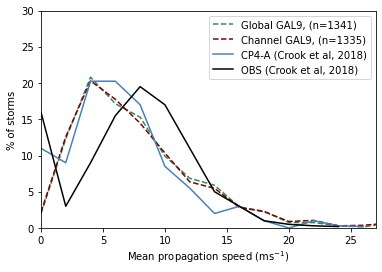

In [7]:
bins=[]
for props in [mcs_prop1,mcs_prop2]:
    mx=np.ceil(props["speeds"].max())
    bins.append(stats.binned_statistic(props["speeds"],props["speeds"],statistic='count',bins=(mx+mx%2)/2 + 1,range=(-1,mx+mx%2 + 1)))

plt.plot(bins[0].bin_edges[:-1]+1,100*bins[0].statistic/np.sum(bins[0].statistic),label="Global GAL9, (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen",ls="--")#"darkseagreen")
plt.plot(bins[1].bin_edges[:-1]+1,100*bins[1].statistic/np.sum(bins[1].statistic),label="Channel GAL9, (n={:.0f})".format(np.sum(bins[1].statistic)),color="maroon",ls="--")#"mediumturquoise")
#plt.plot(bins[2].bin_edges[:-1]+1,100*bins[2].statistic/np.sum(bins[2].statistic),label="Channel RAL3, (n={:.0f})".format(np.sum(bins[2].statistic)),color="maroon")
#Values read manually off fig 6a of Crook et al, 2018
cp4=[11,9,20.25,20.25,17,8.5,5.5,2,3,1,0,1,0.3,0.2]
plt.plot(np.arange(0,2*len(cp4),2),cp4,label="CP4-A (Crook et al, 2018)",color="steelblue")
#plt.plot(bins[3].bin_edges[:-1]+1,100*bins[3].statistic/np.sum(bins[3].statistic),label="LAM RAL3, (n={:.0f})".format(np.sum(bins[3].statistic)),color="goldenrod")
#Values read manually off fig 6a of Crook et al, 2018
obs=[16,3,9,15.5,19.5,17,11,5,3,1,0.5,0.3,0.2]
plt.plot(np.arange(0,2*len(obs),2),obs,label="OBS (Crook et al, 2018)",color="k")
plt.legend()
plt.xlabel("Mean propagation speed (ms$^{-1}$)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[::5],np.arange(0,30,5))
plt.xlim([0,27])#improves shear response of intense rainfall from MCSs
plt.ylim([0,30])
plt.savefig("MCS_propogation_speed_model_distributions.png",dpi=200)

(0.0, 25.0)

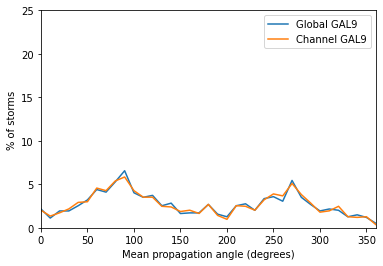

In [8]:
bins=[]
for props in [mcs_prop1, mcs_prop2]:
    bins.append(stats.binned_statistic(props["dirs"],props["dirs"],statistic='count',bins=37,range=(-5,365)))

plt.plot(bins[0].bin_edges[:-1]+5,100*bins[0].statistic/np.sum(bins[0].statistic),label="Global GAL9")
plt.plot(bins[1].bin_edges[:-1]+5,100*bins[1].statistic/np.sum(bins[1].statistic),label="Channel GAL9")
#plt.plot(bins[2].bin_edges[:-1]+5,100*bins[2].statistic/np.sum(bins[2].statistic),label="Channel RAL3")
#plt.plot(bins[3].bin_edges[:-1]+1,100*bins[3].statistic/np.sum(bins[3].statistic),label="LAM RAL3")
plt.legend()
plt.xlabel("Mean propagation angle (degrees)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[:-1:5],[int(i) for i in (bins[0].bin_edges[:-1:5]+5)])
plt.xlim([0,360])
plt.ylim([0,25])

In [9]:
print(len(mcs_prop1),len(mcs_prop2))

1341 1335
